In [1]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
nu = 5e-5
Prandtl = 1
kappa = nu/Prandtl
kolmogorov_time = 1e-3
kolmogorov_length = 1


Lx = info['lx']
Ly = info['ly']
Lz = info['lz']

Top = Ly/2
Bottom = -Ly/2

eps = Ly/100

npoints = 10
nparticles = 1000
nsteps = info['time'].shape[0]
nsteps = nsteps



x0         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = Lx*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//25]
x0[..., 2] = Lz*np.random.random(size = (npoints,))[:, None]
x               = x0.copy()
LB              = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
LT              = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
HT              = (info['time'][-1]+1)**2*np.ones(shape = (npoints, nparticles, 1), dtype = np.float32)


T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num = subdivisions*nsteps+1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5
noiseamplitude  = (2*kappa)**.5

In [3]:
lJHTDB = libJHTDB()
lJHTDB.initialize()

for tindex in range(nsteps):
    print('step {0}'.format(tindex))
    u = lJHTDB.getData(
                t[tindex],
                x,
                sinterp = interpolation_code['M2Q8'],
                tinterp = interpolation_code['NoTInt'],
                data_set = info['name'],
                getFunction = 'getVelocity')
    dW = np.random.randn(*x.shape)*sqrtdt
    dX = -u*dt + noiseamplitude*dW
    x += dX
    cond1 = x[..., 1] < Bottom + eps
    cond2 = x[..., 1] > Top    - eps
    HT[np.logical_or(cond1, cond2)] = np.minimum(HT[np.logical_or(cond1, cond2)], tau[tindex])
    c1indices = np.where(cond1)   
    if c1indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c1indices]
        Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2
        dL =  Y - x[c1indices] + Bottom
        dL[np.where(dL < 0)] = 0
        x[c1indices]  += dL
        LB[c1indices] += dL/kappa
    c2indices = np.where(cond2) 
    if c2indices[0].size > 0:
        V  =  -2*dt*np.log(np.random.random(x.shape))[c2indices]
        Y  = (-dX[c2indices] + np.sqrt(2*kappa*V + dX[c2indices]**2))/2
        dL =  Y + x[c2indices] - Top
        dL[np.where(dL < 0)] = 0
        x[c2indices]  -= dL
        LT[c2indices] += dL/kappa
    x[..., 1] = np.clip(x[..., 1], Bottom, Top)
lJHTDB.finalize() 

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

In [8]:
####### Dump Data #######

pickle.dump(x, open( "data_channel/x.p", "wb" ) )
pickle.dump(t, open( "data_channel/t.p", "wb" ) )
pickle.dump(LT, open( "data_channel/LT.p", "wb" ) )
pickle.dump(LB, open( "data_channel/LB.p", "wb" ) )

####### Load Data #######

#x = pickle.load( open( "data_channel/x.p", "rb" ) )
#t = pickle.load( open( "data_channel/t.p", "rb" ) )
#LT = pickle.load( open( "data_channel/LT.p", "rb" ) )
#LB = pickle.load( open( "data_channel/LB.p", "rb" ) )

<IPython.core.display.Javascript object>


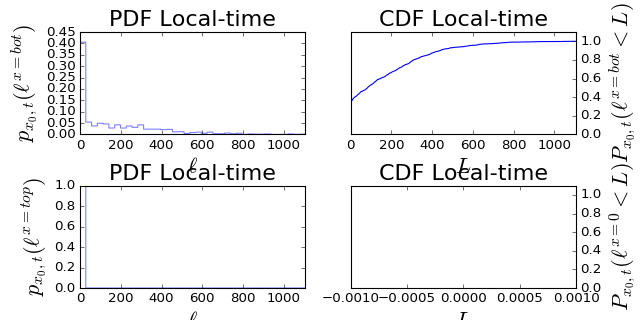

In [24]:
space_index   =  0
dataB         = LB[space_index,:,1]
dataT         = LT[space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')
#ax1.hist(dataB, normed = 1, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')


ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)




bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataT[:])/N
ax3.hist(dataT, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax3.set_title('PDF Local-time', fontsize=20)
ax3.set_xlim([0,MB])
ax3.set_xlabel('$\ell$', fontsize=20)
ax3.set_ylabel('$p_{x_0,t}(\\ell^{x=top})$', fontsize=20)

values, base = np.histogram(dataT, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')


ax4.set_xlim([0,MT])
ax4.set_ylim([0,1.1])
ax4.set_title('CDF Local-time', fontsize=20)
ax4.set_xlabel('$L$', fontsize=20)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


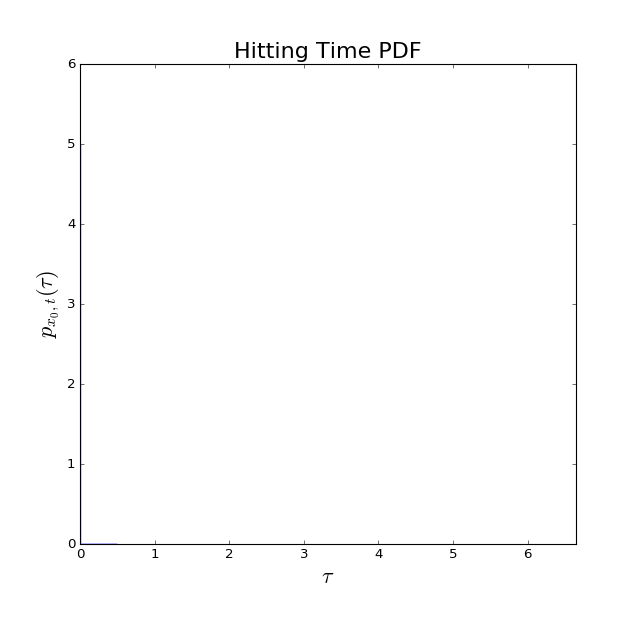

In [5]:
space_index1 = 0
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

data1 = HT[space_index1, :, np.newaxis]
data1 = data1[data1 < (T+1)**2]
MD1 = np.max(data1)

N = nparticles/5
weights1 = np.ones_like(data1[:])/N

ax1.hist(data1, weights = weights1, bins = 100, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0,T])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

In [6]:
HT

array([[[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]],

       ..., 
       [[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]]], dtype=float32)

In [33]:
LT

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]], dtype=float32)